## Training the benchmarking models using the original parameters 

Differences from previous round : 
- 925 dense layer units for DanQ (ref : https://github.com/uci-cbcl/DanQ/blob/master/DanQ_train.py )  and DeepSEA (ref :https://static-content.springer.com/esm/art%3A10.1038%2Fnmeth.3547/MediaObjects/41592_2015_BFnmeth3547_MOESM644_ESM.pdf ) 
- 100 dense layer units for DeepAtt (ref: https://github.com/jiawei6636/Bioinfor-DeepATT/blob/651b0dc722fcf2407ef88b8c84587ca92ec1bdc1/model/model.py#L37 )
- Single dense layer before output layer


#### Load the chosen benchmarking model ( DeepSEA_original / DeepAtt_original / DanQ _original)
The saved model is available in this directory under the name `[model_name].h5`


##### Note about the final layer :

We emphasize that the final layer does have a <b>single output unit and a linear activation</b> as one would expect. This is can be verified by looking at the following line in the `benchmarking.py` file in this folder and also in the cell below : <br>
<code>output_layer = Dense(1, kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight),
                     activation='linear', kernel_initializer='he_normal', use_bias=True )(x) 
</code>


#####  Note about the DeepAtt() model : 

- The reader will notice that there is a fitness_function_model() call instead of DeepAtt() for the model_name = 'DeepAtt'. The reason is that there are some non JSON-serializable layers in the DeepAtt() function invocation (from their original authors) which makes it difficult to save using model.save(). The model can be trained (using notebook 2 in this folder) but the jupyter notebook needs to be kept running for the complete analysis (including computing predictions and computing ECC using this model) since model.save_weights() results in errors when loading and model.save() will not work. 
- The ECC for DeepAtt was also similarly calculated using this single running notebook from end to end using the DeepAtt() call to stay faithful to the original implementation. We also save a model trained using our own implementation of the DeepAtt() model with JSON-seriable layers for future predictions.
- So, to save a version of the 'DeepAtt' model, we use our own layers to address the issues we had in saving with the implementation in DeepAtt() from the original authors. 
- It can be verified that both lead to equivalent performance by changing the 'define_DeepAtt_here' flag in Notebook 2 and the bechmarking.py file.
- The DeepAtt() model was trained from scratch here again (in this same VM and environment) using both approaches (our adapted approach and the original authors approach) to verify the equivalent peformance and it worked as expected consistently.


In [1]:
%matplotlib inline

In [2]:
train = 0 ### since we have already trained and saved the models. Change if you want to retrain from scratch

#### Imports

In [3]:
import BioinforDeepATT
from BioinforDeepATT.model.model import *
import sys
sys.path.insert(0, './')

from rr_aux import *

define_DeepAtt_here= 1 ### 
### Change this to 1 if you would like to save a new model.
save = 1

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3

#### Load Data

In [4]:



##Clear Memory 
#tf.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()
##



NUM_GPU = len(get_available_gpus())
if(NUM_GPU>0) :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

print(tf.__version__)
print(keras.__version__)

model_conditions = 'Glu'


#sys.argv[1] appended to beginning of path
dir_path=os.path.join('..','..','..','data',model_conditions)


###


if train: 


    ## Load the data matrix
    with h5py.File(join(dir_path,'_trX.h5'), 'r') as hf:
        _trX = hf['_trX'][:]

    with h5py.File(join(dir_path,'_trY.h5'), 'r') as hf:
        _trY = hf['_trY'][:]

    with h5py.File(join(dir_path,'_vaX.h5'), 'r') as hf:
        _vaX = hf['_vaX'][:]

    with h5py.File(join(dir_path,'_vaY.h5'), 'r') as hf:
        _vaY = hf['_vaY'][:]

    with h5py.File(join(dir_path,'_teX.h5'), 'r') as hf:
        _teX = hf['_teX'][:]

    with h5py.File(join(dir_path,'_teY.h5'), 'r') as hf:
        _teY = hf['_teY'][:]



    _trX.shape , _trY.shape , _vaX.shape , _vaY.shape  , _teX.shape , _teY.shape



    trX = _trX[:int(_trX.shape[0]/1024)*1024] #np.concatenate((_trX, _trX_rc), axis = 1) #np.squeeze((_trX))#
    vaX = _vaX[:int(_vaX.shape[0]/1024)*1024] # np.concatenate((_vaX, _vaX_rc), axis = 1) #np.squeeze((_vaX))#
    teX = _teX[:int(_teX.shape[0]/1024)*1024] # np.concatenate((_teX, _teX_rc), axis = 1)#np.squeeze((_teX))#



    ## Load the scaler function (scaler was trained on the synthesized data
    scaler = sklearn.externals.joblib.load(join(dir_path,'scaler.save')) 




    vaY = (scaler.transform(_vaY.reshape(1, -1))).reshape(_vaY.shape)[:int(_vaY.shape[0]/1024)*1024] #_vaY#
    trY = (scaler.transform(_trY.reshape(1, -1))).reshape(_trY.shape)[:int(_trY.shape[0]/1024)*1024] #_trY#
    teY = (scaler.transform(_teY.reshape(1, -1))).reshape(_teY.shape)[:int(_teY.shape[0]/1024)*1024] #_teY#

    ### If using generator, have a smaller val set for faster evaluation
    if 0: 
        s_trX = np.vstack((trX , vaX))
        s_trY = np.vstack((trY , vaY))
        trX = s_trX[1000:,:]
        trY = s_trY[1000:,:]
        vaX = s_trX[0:1000,:]
        vaY = s_trY[0:1000,:]

    print(trX.shape , trY.shape , vaX.shape , vaY.shape  , _teX.shape , _teY.shape)

    input_shape = trX.shape




1.14.0
2.2.4-tf


#### Load model with original parameters 

In [5]:



def fitness_function_model(model_params) :

    batch_size= model_params['batch_size']
    l1_weight= model_params['l1_weight']
    l2_weight= model_params['l2_weight']
    lr= model_params['lr']
    device_type = model_params['device_type']
    input_shape = model_params['input_shape']
    loss = model_params['loss']
    model_name = model_params['model_name']
    
    if(model_params['device_type']=='tpu'):
        input_layer = Input(batch_shape=(batch_size,input_shape[1],input_shape[2]))  #trX.shape[1:] #batch_shape=(batch_size,110,4)

    else :
        input_layer = Input(shape = input_shape[1:] , batch_size = 1024)  #trX.shape[1:] #

    if model_name=='DeepAtt_original':
        if define_DeepAtt_here : 
            x = Conv1D(256, 30, padding='valid' ,\
                   kernel_regularizer  = l1_l2(l1=l1_weight, l2=l2_weight), kernel_initializer='he_normal' ,
                  data_format = 'channels_last' , activation='relu')(input_layer) 
            x = tf.keras.layers.MaxPool1D( pool_size=3, strides=3, padding='valid')(x)
            x= tf.keras.layers.Dropout(0.2)(x)
            x = Bidirectional(LSTM(16, return_sequences=True,kernel_initializer='he_normal'))(x)
            x = MultiHeadAttention( head_num=16)(x) 
            x = tf.keras.layers.Dropout(0.2)(x)
            x = Flatten()(x)

            x = keras.layers.Dense(
                    units=100,
                    activation='relu')(x)

        else :  ### use original implementation, cannot be saved ! 
            x = DeepAtt()
            x = x.call(input_layer)

    if model_name=='DanQ_original':
        x = DanQ_original()
        x = x.call(input_layer)

    if model_name=='DeepSEA_original':
        x = DeepSEA_original()
        x = x.call(input_layer)

    if(len(x.get_shape())>2):
        x = Flatten()(x) 
        
    output_layer = Dense(1, kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight),
                    activation='linear', kernel_initializer='he_normal', use_bias=True )(x) 


    model = Model(input_layer, output_layer)
    opt = tf.compat.v1.train.AdamOptimizer(lr) #tf.keras.optimizers.Adam(lr=lr)#
    

    model.compile(optimizer=opt, loss=loss,metrics=['mean_squared_error', 'cosine_similarity']) 
    
    return model


In [6]:

model_name_list = ['DeepAtt_original', 'DeepSEA_original' , 'DanQ_original'  ] # 

if train : 
    for model_name in model_name_list : 
        model_params = {
            'n_val_epoch' : 1000,
            'epochs' : 3, #3 used previously
            'batch_size': int(1024*1), # int(1024*3) , #64*55 fits , #best batch size is 1024
            'l1_weight': 0,#1e-6#1e-7#0.01 # l1 should always be zero
            'l2_weight': 0,#1e-7#0.01
            'lr':0.001,
            'device_type' : 'gpu', #'tpu'/'gpu'/'cpu'
            'input_shape' : input_shape,
            'loss' : 'mean_squared_error', 
            'model_name' : model_name}
        epochs = model_params['epochs']  
        batch_size =  model_params['batch_size']
        n_val_epoch =  model_params['n_val_epoch']
        epochs = model_params['epochs']



        if save :  ### Change to 1 if you would like to update the saved parameter file
            ### Save model params as csv
            w = csv.writer(open(os.path.join(model_name+'_model_params.csv'), "w"))
            for key, val in model_params.items():
                w.writerow([key, val])

            ### Save model params as pickle
            f = open(os.path.join(model_name+'_model_params.pkl'),"wb")
            pickle.dump(model_params,f)
            f.close()


        model=fitness_function_model(model_params)

        print(model.summary())

        model.fit(trX, trY, validation_data = (vaX[:1024], vaY[:1024]), batch_size=batch_size  , epochs=epochs  )
        #model.fit_generator(training_generator, validation_data = (teX[:100], teY[:100]),
        #epochs=epochs , steps_per_epoch = 10240)#int(trX.shape[0]/(batch_size*n_val_epoch)) )
        #model.save_weights(model_name)

        def read_hq_testdata(filename) :

            with open(filename) as f:
                reader = csv.reader(f, delimiter="\t")
                d = list(reader)

            sequences = [di[0] for di in d]

            for i in tqdm(range(0,len(sequences))) : 
                if (len(sequences[i]) > 110) :
                    sequences[i] = sequences[i][-110:]
                if (len(sequences[i]) < 110) : 
                    while (len(sequences[i]) < 110) :
                        sequences[i] = 'N'+sequences[i]



            A_onehot = np.array([1,0,0,0] ,  dtype=np.bool)
            C_onehot = np.array([0,1,0,0] ,  dtype=np.bool)
            G_onehot = np.array([0,0,1,0] ,  dtype=np.bool)
            T_onehot = np.array([0,0,0,1] ,  dtype=np.bool)
            N_onehot = np.array([0,0,0,0] ,  dtype=np.bool)

            mapper = {'A':A_onehot,'C':C_onehot,'G':G_onehot,'T':T_onehot,'N':N_onehot}
            worddim = len(mapper['A'])
            seqdata = np.asarray(sequences)
            seqdata_transformed = seq2feature(seqdata)
            print(seqdata_transformed.shape)


            expressions = [di[1] for di in d]
            expdata = np.asarray(expressions)
            expdata = expdata.astype('float')  

            return np.squeeze(seqdata_transformed),expdata


        X,Y = read_hq_testdata(os.path.join('..','..','..','data','Glu','HQ_testdata.txt'))
        Y = [float(x) for x in Y]
        Y_pred= evaluate_model(X, model, scaler)

        pcc = scipy.stats.pearsonr(Y,Y_pred )[0]
        print(pcc)

        df = pd.DataFrame({'Y' : Y , 'Y_pred' : Y_pred , 'pcc' : pcc})

        if save : ### Please change this to 1 if you would like to save the new results
            df.to_csv(model_name+"_results.csv")
            model.save(model_name+"_model.h5")
            #model.save_weights(model_name)


# Prediction performance on Random Test Data (corresponding to Fig. 1b)

### DeepAtt_original 

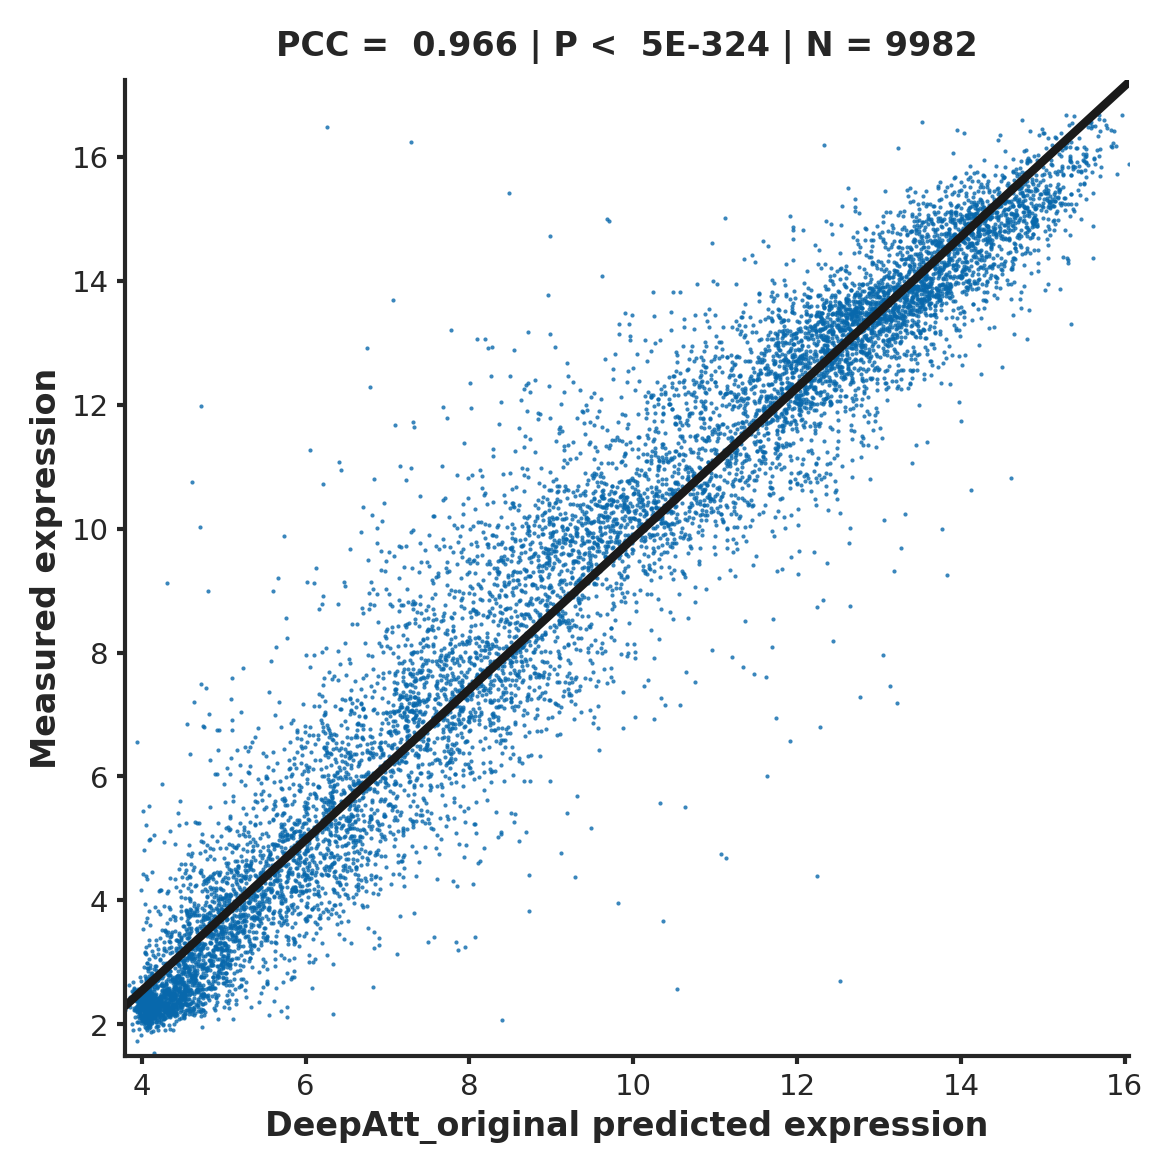

In [7]:
model_name = 'DeepAtt_original'

df = pd.read_csv(model_name + '_results.csv', index_col = 0 )
expressions = df['Y'].values
predicted_expressions = df['Y_pred'].values


fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)
plt.show()

### DeepSEA_original 

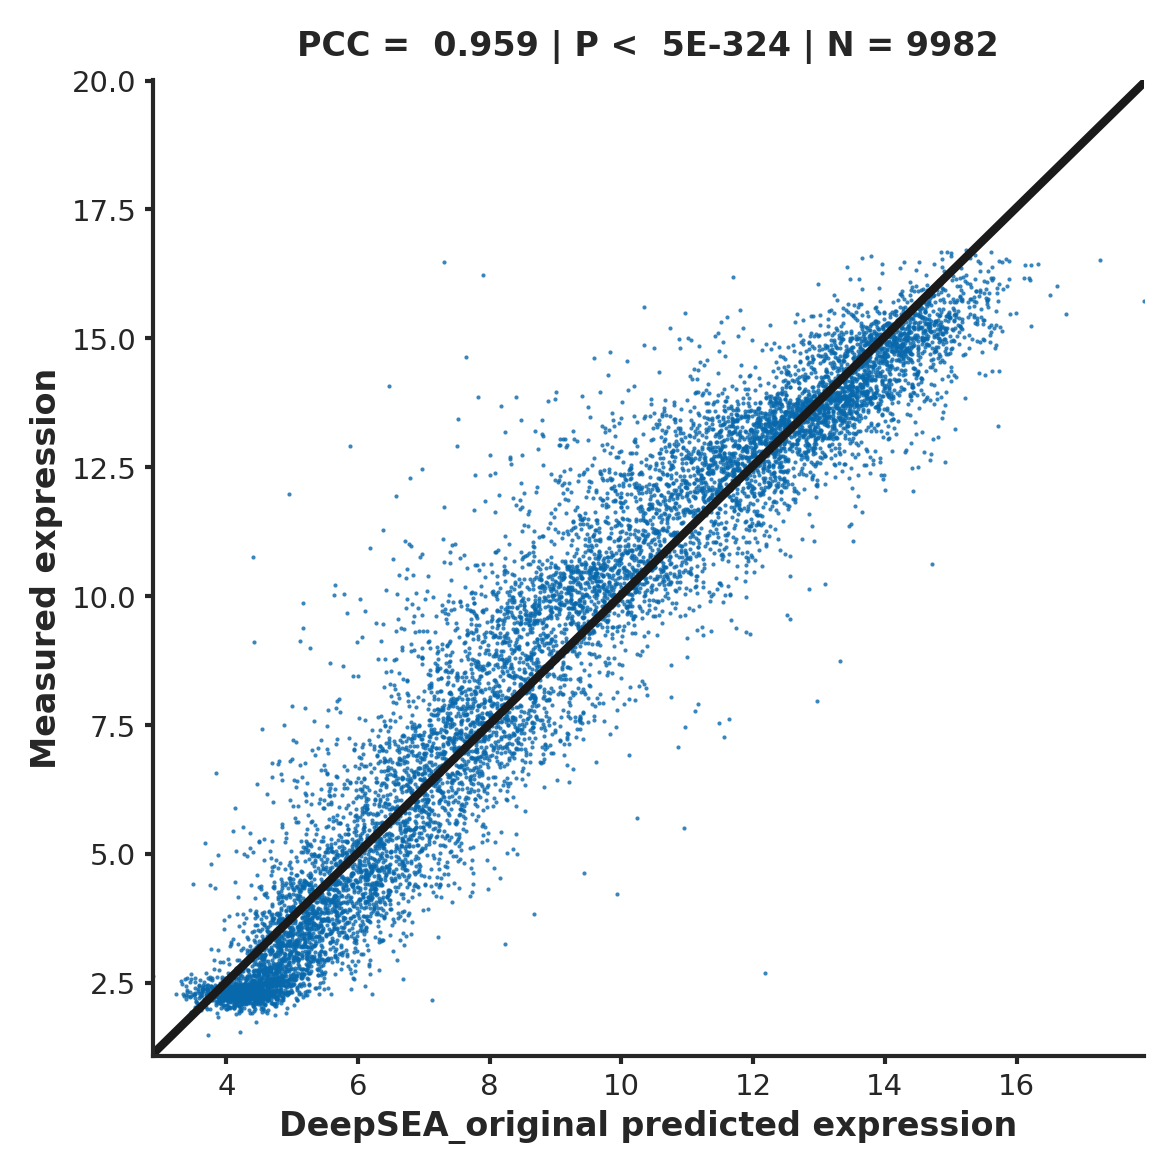

In [8]:
model_name = 'DeepSEA_original'

df = pd.read_csv(model_name + '_results.csv', index_col = 0 )
expressions = df['Y'].values
predicted_expressions = df['Y_pred'].values


fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)

plt.show()

### DanQ_original 

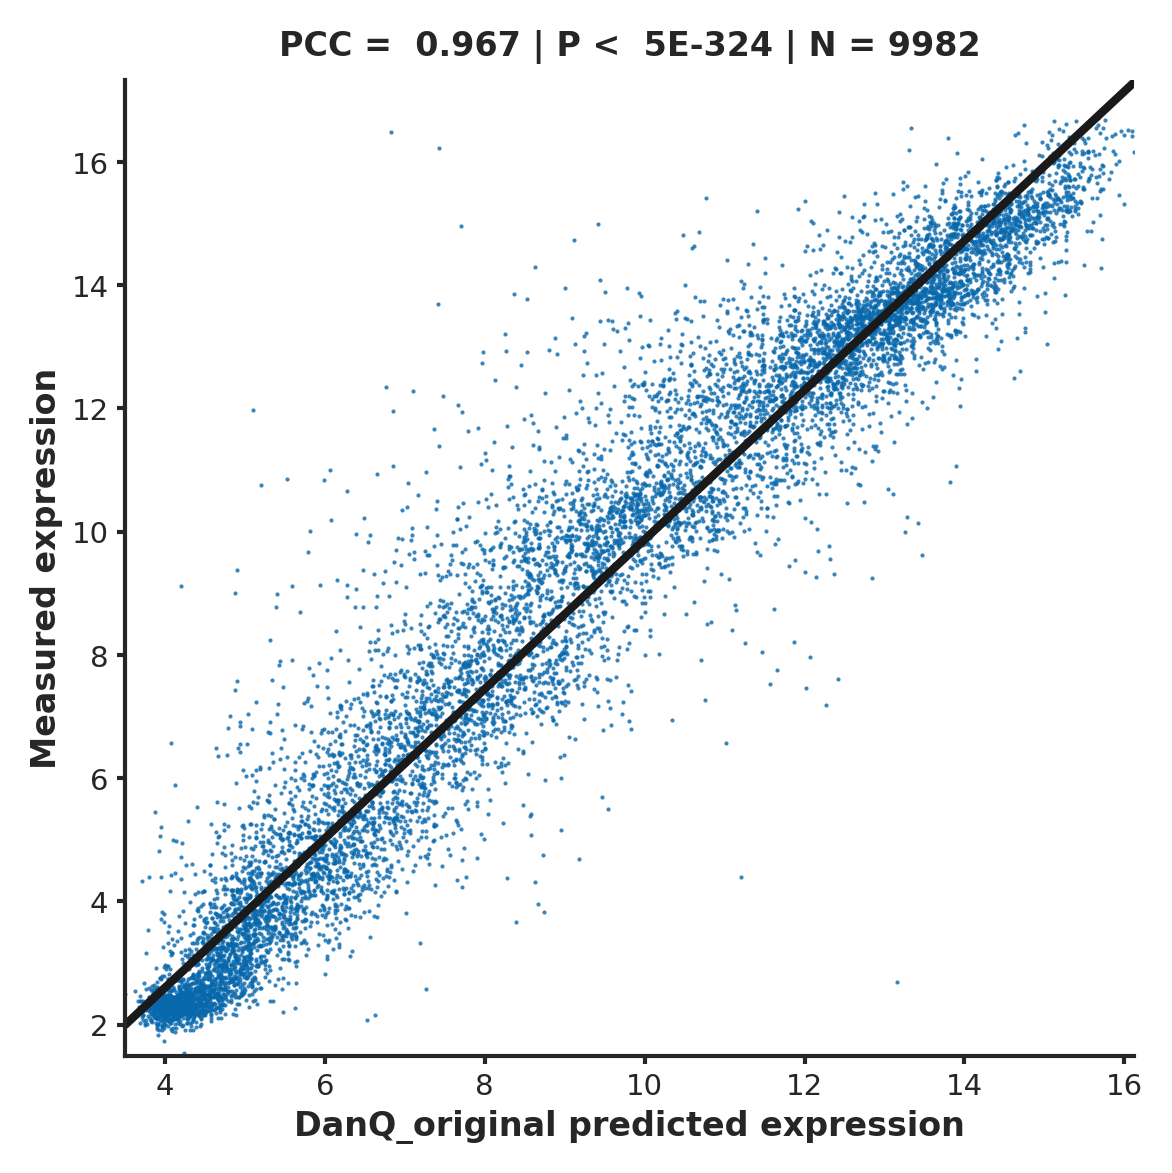

In [9]:
model_name = 'DanQ_original'

df = pd.read_csv(model_name + '_results.csv', index_col = 0 )
expressions = df['Y'].values
predicted_expressions = df['Y_pred'].values


fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)

plt.show()